In [1]:
import numpy as np
import pandas as pd

from rdkit import RDLogger
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize.standardize import canonicalize_tautomer_smiles

from descriptors import calc_MACCS_keys_fingerprint, calc_flat_ring_properties, calc_rdkit_properties, calc_morgan_fingerprints, calc_cats2d_descriptors

pd.set_option('display.max_colwidth', 1000)


In [2]:
print(f'RDKit version: {rdBase.rdkitVersion}')

RDKit version: 2021.03.3


In [3]:
df_excel = pd.read_excel("./data/tx9b00338_si_001.xls", sheet_name="PIH")
df_excel.head()

,Substance,Canonical_Smiles,Set,Clinical,Post-Marketing,Lit/Legacy,Photosensitation
0,5-Methoxypsoralen,COc1c2C=CC(=O)Oc2cc3occc13,Train,x,NaN,NaN,yes
1,Abacavir,Nc1nc(NC2CC2)c3ncn([C@@H]4C[C@H](CO)C=C4)c3n1,Train,x,x,NaN,yes
2,Acamprosate,CC(=O)NCCCS(=O)(=O)O,Train,x,NaN,NaN,yes
3,Acebutolol,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(=O)C,Train,x,(x),NaN,yes
4,Aceclofenac,OC(=O)COC(=O)Cc1ccccc1Nc2c(Cl)cccc2Cl,Test,x,NaN,NaN,yes


In [4]:
# Replace end of line in substance names
# df_excel['Substance'] = df_excel['Substance'].str.replace("\n","|")

In [5]:
# The column Set contains the dataset split information used in the model evaluation
df_excel.Set.value_counts()

Train    1006
Test      307
Ext       104
Name: Set, dtype: int64

In [6]:
def parent(smiles):
    '''Get parent of a smiles'''
    try:
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            raise Exception("MolFromSmiles failed")
        m = rdMolStandardize.FragmentParent(m)
        return Chem.MolToSmiles(m)
    except:
        print(f"{smiles} failed conversion")
        return np.nan

def clean_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        Chem.SanitizeMol(mol)
        mol = Chem.RemoveHs(mol)
        mol = rdMolStandardize.MetalDisconnector().Disconnect(mol)
        mol = rdMolStandardize.Normalize(mol)
        mol = rdMolStandardize.Reionize(mol)
        Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
        return Chem.MolToSmiles(mol)
    except:
        print(f"{smiles} failed conversion")
        return np.nan
    
def canonical_tautomer(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        enumerator = rdMolStandardize.TautomerEnumerator()
        enumerator.Canonicalize(m)
        return Chem.MolToSmiles(mol)
    except:
        print(f"{smiles} failed conversion")
        return np.nan

def clean_data(data, canonicalize=True):
    '''Clean and standardize the data'''
    data = data.copy()
    
    # Replace newlines in smiles
    data['smiles'] = data['smiles'].str.replace("\n","")

    # Remove missing smiles
    data = data[data['smiles'].notnull()]
    
    # Standardize and get parent
    data["smiles_parent"] = data['smiles'].apply(parent)
    
    # Remove rows with missing parent smiles
    data = data[data['smiles_parent'].notnull()]

    # Standardize parent smiles
    data["smiles_clean"] = data['smiles_parent'].apply(clean_smiles)
    
    # Remove rows with missing cleaned smiles
    data = data[data['smiles_clean'].notnull()]

    # Filter out small fragments
    def NumAtoms(smile):
        return Chem.MolFromSmiles(smile).GetNumAtoms()
    data["NumAtoms"] = data["smiles_clean"].apply(NumAtoms)
    data = data[data["NumAtoms"] > 3]
    data.drop(columns=['NumAtoms'],inplace = True)

    # Canonicalalize tautomer smiles
    if canonicalize:
        data["Canonical_Smiles"] = data["smiles_clean"].apply(canonicalize_tautomer_smiles)
    else:
        data["Canonical_Smiles"] = data["smiles_clean"]

    return data

data = df_excel.rename(columns={"Canonical_Smiles": "smiles"})
num_mols_before =  data.shape[0]

RDLogger.DisableLog('rdApp.info')
RDLogger.DisableLog('rdApp.error')
data = clean_data(data, canonicalize=True)
data.reset_index(drop=True, inplace=True)
RDLogger.EnableLog('rdApp.info')
RDLogger.DisableLog('rdApp.error')

num_mols_after =  data.shape[0]
print("-"*30)
print(f'#Molecules before cleaning: {num_mols_before}')
print(f'#Molecules  after cleaning: {num_mols_after}')


S1c2ccccn2=[O][Zn]13Sc4ccccn4=[O]3 failed conversion
CO[C@H]1O[C@H](COS(=O)(=O)O)[C@@H](O[C@@H]2O[C@H]([C@@H](O[C@H]3O[C@H](COS(=O)(=O)O)[C@@H](O[C@@H]4O[C@@H]([C@@H](O[C@H]5O[C@H](COS(=O)(=O)O)[C@@H](O)[C@H](O)[C@H]5NS(=O)(=O)O)[C@H](O)[C@H]4O)C(=O)O)[C@H](OS(=O)(=O)O)[C@H]3NS(=O)(=O)O)[C@H](O)[C@H]2OS... failed conversion
ON(=O)=[O][Ga](ON(=O)=O)[O]=N(=O)O failed conversion
ON(=O)=[O][C@@H]1CO[C@H]2[C@@H]1OC[C@@H]2[O]=N(=O)O failed conversion
O[C@H]1CO[C@H]2[C@@H]1OC[C@H]2[O]=N(=O)O failed conversion
ON(=O)=[O]CC(CON(=O)=O)[O]=N(=O)O failed conversion
------------------------------
#Molecules before cleaning: 1417
#Molecules  after cleaning: 1408


In [7]:
# Check smiles that failed conversion to molecules during clean up
df = df_excel[["Substance","Canonical_Smiles"]].set_index("Substance").join(data.set_index("Substance"),rsuffix="_original")
df_failed_cleanup = df.loc[df['smiles_parent'].isnull(),["Canonical_Smiles"]]
df_failed_cleanup

,Canonical_Smiles
Substance,
Ethanol,CCO
Fondaparinux,CO[C@H]1O[C@H](COS(=O)(=O)O)[C@@H](O[C@@H]2O[C@H]([C@@H](O[C@H]3O[C@H](COS(=O)(=O)O)[C@@H](O[C@@H]4O[C@@H]([C@@H](O[C@H]5O[C@H](COS(=O)(=O)O)[C@@H](O)[C@H](O)[C@H]5NS(=O)(=O)O)[C@H](O)[C@H]4O)C(=O)O)[\nC@H](OS(=O)(=O)O)[C@H]3NS(=O)(=O)O)[C@H](O)[C@H]2OS...
Gallium Nitrate,ON(=O)=[O][Ga](ON(=O)=O)[O]=N(=O)O
Isosorbide,ON(=O)=[O][C@@H]1CO[C@H]2[C@@H]1OC[C@@H]2[O]=N(=O)O
Isosorbide,O[C@H]1CO[C@H]2[C@@H]1OC[C@H]2[O]=N(=O)O
Nitroglycerin,ON(=O)=[O]CC(CON(=O)=O)[O]=N(=O)O
"Nitroprusside,",O=N[Fe](C#N)(C#N)(C#N)(C#N)C#N
Pyrithione,S1c2ccccn2=[O][Zn]13Sc4ccccn4=[O]3
Sodium Nitrite,ON=O


O=N[Fe](C#N)(C#N)(C#N)(C#N)C#N


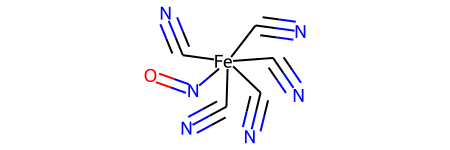

In [8]:
# Check structures without sanitation
smiles = df_failed_cleanup.loc["Nitroprusside,"].values[0]
print(smiles)
Chem.MolFromSmiles(smiles,sanitize=False)

Failure reason: Coordinated metal complex 

ON(=O)=[O][Ga](ON(=O)=O)[O]=N(=O)O


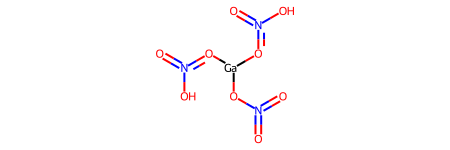

In [9]:
# Check structures without sanitation
smiles = df_failed_cleanup.loc["Gallium Nitrate"].values[0]
print(smiles)
Chem.MolFromSmiles(smiles,sanitize=False)

Failure reason: Coordinated metal complex

S1c2ccccn2=[O][Zn]13Sc4ccccn4=[O]3


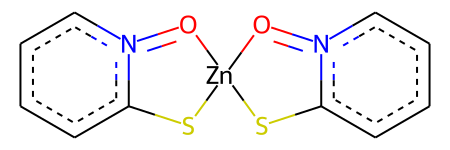

In [10]:
# Check structures without sanitation
smiles = df_failed_cleanup.loc["Pyrithione"].values[0]
print(smiles)
Chem.MolFromSmiles(smiles,sanitize=False)

Failure reason: Coordinated metal complex

In [11]:
# Check structures without sanitation
smiles = df_failed_cleanup.loc["Fondaparinux"].values[0]
print(smiles)
Chem.MolFromSmiles(smiles,sanitize=False)

CO[C@H]1O[C@H](COS(=O)(=O)O)[C@@H](O[C@@H]2O[C@H]([C@@H](O[C@H]3O[C@H](COS(=O)(=O)O)[C@@H](O[C@@H]4O[C@@H]([C@@H](O[C@H]5O[C@H](COS(=O)(=O)O)[C@@H](O)[C@H](O)[C@H]5NS(=O)(=O)O)[C@H](O)[C@H]4O)C(=O)O)[
C@H](OS(=O)(=O)O)[C@H]3NS(=O)(=O)O)[C@H](O)[C@H]2OS...


Reason: SMILEs string is truncated with ...

In [12]:
# Keep required columns
keep = ["Substance", "Canonical_Smiles", "Set", "Photosensitation"]
df_mols = data[keep].copy()

# Add molecules to dataframe
num_mols_before =  df_mols.shape[0]
PandasTools.AddMoleculeColumnToFrame(df_mols,'Canonical_Smiles','Molecule')

# Check for empty molecules
print("Failed conversion of smiles:")
print(df_mols[df_mols.Molecule.isnull()])

# Drop rows with empty molecules
df_mols = df_mols[df_mols.Molecule.notnull()]
df_mols.reset_index(drop=True, inplace=True)
num_mols_after =  df_mols.shape[0]

print(f'#Molecules before dropping: {num_mols_before}')
print(f'#Molecules  after dropping: {num_mols_after}')


Failed conversion of smiles:
Empty DataFrame
Columns: [Substance, Canonical_Smiles, Set, Photosensitation, Molecule]
Index: []
#Molecules before dropping: 1408
#Molecules  after dropping: 1408


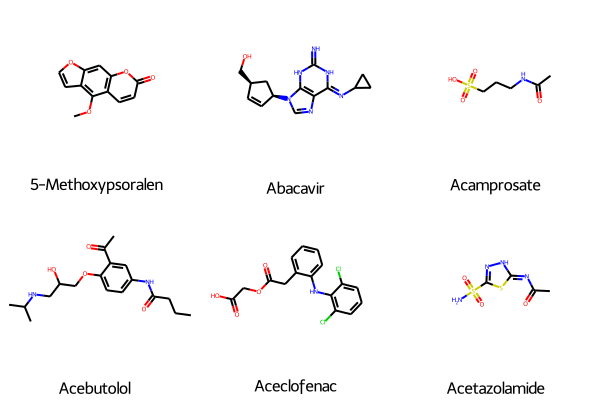

In [13]:
PandasTools.FrameToGridImage(df_mols[:6], column='Molecule', legendsCol='Substance')

In [14]:
# keep = ["Substance", "smiles", "Canonical_Smiles"]
# df_check = data[keep].copy()
# df_check.to_excel("./data/phototox_clean.xlsx", index=False)


In [15]:
# Columns to keep from df_mols
keep = ["Substance", "Canonical_Smiles", "Set", "Photosensitation"]

# Calculate features
maccs_features, maccs_columns = calc_MACCS_keys_fingerprint(df_mols['Molecule'])
flatring_features, flatring_columns = calc_flat_ring_properties(df_mols['Molecule'])
rdkit_features, rdkit_columns = calc_rdkit_properties(df_mols['Molecule'])
fingerprint_features, fingerprint_columns = calc_morgan_fingerprints(df_mols['Molecule'], nBits=1024, radius=3)
cats_features, cats_columns = calc_cats2d_descriptors(df_mols['Molecule'])

# Write file with CATS features
df = pd.DataFrame(data=cats_features, columns=cats_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_cats.csv", index=False)

# Write file with MACCS features
df = pd.DataFrame(data=maccs_features, columns=maccs_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_maccs.csv", index=False)

# Write file with rdkit features
df = pd.DataFrame(data=rdkit_features, columns=rdkit_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_rdkit.csv", index=False)

# Write file with flat ring features
df = pd.DataFrame(data=flatring_features, columns=flatring_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_flatring.csv", index=False)

# Write file with fingerprint features
df = pd.DataFrame(data=fingerprint_features, columns=fingerprint_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_fps.csv", index=False)

# Combine flatring with MACCS features
flatring_maccs_features = np.hstack([flatring_features, maccs_features])
flatring_maccs_columns  = np.hstack([flatring_columns, maccs_columns])

df = pd.DataFrame(data=flatring_maccs_features, columns=flatring_maccs_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_flatring_maccs.csv", index=False)

# Combine flatring with CATS features
flatring_cats_features = np.hstack([flatring_features, cats_features])
flatring_cats_columns  = np.hstack([flatring_columns, cats_columns])

df = pd.DataFrame(data=flatring_cats_features, columns=flatring_cats_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_flatring_cats.csv", index=False)

# Combine rdkit with flatring and CATS features
flatring_rdkit_cats_features = np.hstack([flatring_features, rdkit_features, cats_features])
flatring_rdkit_cats_columns  = np.hstack([flatring_columns, rdkit_columns, cats_columns])

df = pd.DataFrame(data=flatring_rdkit_cats_features, columns=flatring_rdkit_cats_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_flatring_rdkit_cats.csv", index=False)

# Combine rdkit with flatring features
flatring_rdkit_features = np.hstack([flatring_features, rdkit_features])
flatring_rdkit_columns  = np.hstack([flatring_columns, rdkit_columns])

df = pd.DataFrame(data=flatring_rdkit_features, columns=flatring_rdkit_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_flatring_rdkit.csv", index=False)

# Combine rdkit with fingerprint features
rdkit_fps_features = np.hstack([rdkit_features, fingerprint_features])
rdkit_fps_columns = np.hstack([rdkit_columns, fingerprint_columns])

df = pd.DataFrame(data=rdkit_fps_features, columns=rdkit_fps_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_rdkit_fps.csv", index=False)

# Combine maccs with fingerprint features
maccs_fps_features = np.hstack([maccs_features, fingerprint_features])
maccs_fps_columns = np.hstack([maccs_columns, fingerprint_columns])

df = pd.DataFrame(data=maccs_fps_features, columns=maccs_fps_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_maccs_fps.csv", index=False)

# Combine flatring with fingerprint features
flatring_fps_features = np.hstack([flatring_features, fingerprint_features])
flatring_fps_columns = np.hstack([flatring_columns, fingerprint_columns])

df = pd.DataFrame(data=flatring_fps_features, columns=flatring_fps_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_flatring_fps.csv", index=False)

# Combine flatring with rdkit and fingerprint features
flatring_rdkit_fps_features = np.hstack([flatring_features, rdkit_features, fingerprint_features])
flatring_rdkit_fps_columns = np.hstack([flatring_columns, rdkit_columns, fingerprint_columns])

df = pd.DataFrame(data=flatring_rdkit_fps_features, columns=flatring_rdkit_fps_columns)
df = df.apply(pd.to_numeric, downcast='integer')
df = df_mols[keep].join(df)
df.to_csv("./data/pih_flatring_rdkit_fps.csv", index=False)

print("Done.")

Done.
